In [15]:
import numpy as np 
import pandas as pd
import xarray as xr

import sys, os
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from wofscast.data_generator import extract_datetime_from_path, load_chunk

from wofscast.data_utils import add_derived_vars, add_tisr_var

import matplotlib.pyplot as plt 

# To display the animation in a Jupyter notebook
from IPython.display import HTML


class TOARadiationFlux:
    EARTHS_TILT = 23.45

    def __init__(self):
        # Solar constant in W/m^2
        self.S0 = 1361
        
    def solar_declination_in_radians(self, day_of_year):
        """Calculate solar declination as a function of day of the year."""
        angle = self.EARTHS_TILT * np.sin(np.radians((360 / 365) * (day_of_year - 81)))
        return np.radians(angle)
    
    def equation_of_time(self, day_of_year):
        """Calculate the equation of time in minutes."""
        B = 2 * np.pi * (day_of_year - 81) / 364
        eot = 9.87 * np.sin(2 * B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)
        return eot  # in minutes
    
    def calculate_solar_time(self, utc_time, longitude, day_of_year):
        """Calculate solar time by applying longitude and equation of time corrections."""
        # Convert longitude to equivalent time (4 minutes per degree of longitude)
        longitude_correction = 4 * longitude
        
        # Equation of time correction
        eot = self.equation_of_time(day_of_year)
        
        # Convert UTC time to fractional hours
        utc_hour = utc_time.hour + utc_time.minute / 60
        
        # Solar time is UTC time corrected by longitude and EoT (in hours)
        solar_time = utc_hour + longitude_correction / 60 + eot / 60
        
        return solar_time

    def hour_angle_in_radians(self, utc_time, longitude, day_of_year):
        """Calculate solar hour angle based on UTC time and longitude."""
        # Calculate solar time
        solar_time = self.calculate_solar_time(utc_time, longitude, day_of_year)
        
        # Hour angle: 15 degrees per hour, relative to solar noon
        hour_angle = 15 * (solar_time - 12)
        
        return np.radians(hour_angle)

    def calculate_flux(self, ds):
        """Calculate TOA solar radiation flux over an xarray Dataset."""
        # Assume the xarray dataset (ds) has time, lat, lon dimensions.
        
        lat_grid = ds['lat']
        lon_grid = ds['lon']
        times = ds['datetime']
        
        # Ensure time is in datetime format
        times = pd.to_datetime(times.values)

        NT = len(times)
        NY, NX = len(lat_grid), len(lon_grid)
        flux = xr.DataArray(np.zeros((NT, NY, NX), dtype=np.float32), 
                            dims=['time', 'lat', 'lon'],
                            coords={'time': times, 'lat': lat_grid, 'lon': lon_grid})

        lat_grid_rad = np.radians(lat_grid)

        for i, datetime_obj in enumerate(times):
            # Get the day of the year (Julian day)
            day_of_year = datetime_obj.timetuple().tm_yday
            
            # Calculate solar declination
            declination_rad = self.solar_declination_in_radians(day_of_year)
            
            # Vectorized hour angle calculation for the entire longitude grid
            hour_angle_rad = self.hour_angle_in_radians(datetime_obj, lon_grid, day_of_year)

            # Vectorized zenith angle calculation
            cos_zenith = np.sin(lat_grid_rad) * np.sin(declination_rad) + \
                         np.cos(lat_grid_rad) * np.cos(declination_rad) * np.cos(hour_angle_rad)

            cos_zenith = np.clip(cos_zenith, -1.0, 1.0)  # Avoid invalid values for arccos
           
            zenith_angle = np.degrees(np.arccos(cos_zenith))

            # Replace NaNs in cos_zenith with 0 (avoids propagation of NaNs)
            cos_zenith = np.nan_to_num(cos_zenith)
            
            # Debugging print statements
            print(f"Time: {datetime_obj}, Day: {day_of_year}")
            print(f"Declination (degrees): {np.degrees(declination_rad):.2f}")
            print(f"Hour Angle (degrees): {np.degrees(hour_angle_rad).mean():.2f}")
            print(f"Cos(Zenith): {cos_zenith.mean():.2f}")
            print(f"Zenith Angle (degrees): {zenith_angle.mean():.2f}")
            
            # Calculate TOA radiation flux, mask out where the sun is below the horizon
            flux[i, :, :] = xr.where(zenith_angle < 90, self.S0 * cos_zenith, 0)
    
        
    
        return flux




def add_batch_and_datetime_coords(ds):
    # This approach assumes the dataset has the 
    # 'history' attribute. Not a robust approach! 
    # Extract the datetime from the path in the history attribute
    path = ds.attrs.get('history', '').split(' ')[-1]
    datetime_str = extract_datetime_from_path(path)
    datetime = pd.to_datetime(datetime_str)
    
    ds.coords['datetime'] = datetime
    
    # Add a new 'batch' dimension and expand the dataset accordingly
    ds = ds.expand_dims('batch', axis=0)
    
    # Create a new coordinate 'datetime' with the shape of ('batch', 'time')
    batch_dim = ds.dims['batch']
    time_dim = ds.dims['time']
    
    # Create a DataArray for 'datetime' with the same shape as the ('batch', 'time') dimension
    datetime_coords = xr.DataArray(
        [[datetime] * time_dim], 
        coords={'batch': ds.coords['batch'], 'time': ds.coords['time']}, 
        dims=['batch', 'time']
    )

    # Assign the new datetime coordinate to the dataset
    ds = ds.assign_coords(datetime=datetime_coords)
    
    return ds

def add_batch_dim(ds):
    return ds.expand_dims('batch')



def add_toa_radiation(ds):
    # Add TOA (top-of-the-atmo) radiation 
    toa_radiation = TOARadiationFlux()
    data = toa_radiation.calculate_flux(ds)
    
    print(data)
    
    ds['toa_radiation'] = data
    
    return ds 


In [16]:
%%time
import xarray as xr
from glob import glob
from datetime import datetime

paths = glob('/work2/wofs_zarr/2019/20190518/1900/ENS_MEM_10/*.zarr')
paths.sort()

def preprocess_fn(ds):
    
    ds = ds.rename({'Time' : 'time'})
    ds = add_batch_and_datetime_coords(ds)
    ds = add_derived_vars(ds)
    #ds = add_tisr_var(ds.isel(batch=0))
    ds = add_toa_radiation(ds.isel(batch=0))
    ds = add_batch_dim(ds)

    return ds 

def add_time_dim_after_concat(ds):
    
    datetimes = ds.datetime.values
    # Convert 'time' dimension to timedeltas from the first time point
    time_deltas = (datetimes - datetimes[0]).astype('timedelta64[ns]')
    ds['time'] = time_deltas
    
    #ds = ds.drop_vars('datetime', errors='ignore')
    
    return ds 

ds =  xr.open_mfdataset(paths[:4], engine='zarr', consolidated=True, 
                       decode_times=False, chunks={},
                        combine='nested', concat_dim='time', 
                       preprocess=preprocess_fn, combine_attrs='drop'
                      )
ds = add_time_dim_after_concat(ds)

Time: 2019-05-18 19:00:00, Day: 138
Declination (degrees): 19.49
Hour Angle (degrees): 9.97
Cos(Zenith): 0.96
Zenith Angle (degrees): 16.90
<xarray.DataArray (time: 1, lat: 300, lon: 300)>
array([[[1335.001 , 1334.9448, 1334.8882, ..., 1304.0802, 1303.9288,
         1303.7771],
        [1334.8899, 1334.8337, 1334.7773, ..., 1303.9774, 1303.826 ,
         1303.6744],
        [1334.7787, 1334.7225, 1334.666 , ..., 1303.8744, 1303.7231,
         1303.5715],
        ...,
        [1288.3384, 1288.2872, 1288.2357, ..., 1260.2043, 1260.0665,
         1259.9285],
        [1288.1346, 1288.0835, 1288.0321, ..., 1260.0111, 1259.8733,
         1259.7354],
        [1287.9305, 1287.8795, 1287.8281, ..., 1259.8175, 1259.6799,
         1259.542 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-05-18T19:00:00
  * lat      (lat) float32 29.61 29.63 29.66 29.69 ... 37.69 37.71 37.74 37.77
  * lon      (lon) float32 -100.6 -100.5 -100.5 -100.5 ... -91.37 -91.34 -91.31
Time: 2019-05-

In [13]:
ds = ds.compute()

In [14]:
ds['toa_radiation']

<xarray.DataArray 'toa_radiation' (batch: 1, time: 4, lat: 300, lon: 300)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat       (lat) float32 29.61 29.63 29.66 29.69 ... 37.69 37.71 37.74 37.77
  * lon       (lon) float32 -100.6 -100.5 -100.5 -100.5 ... -91.37 -91.34 -91.31
  * time      (time) timedelta64[ns] 00:00:00 00:05:00 00:10:00 00:15:00
    datetime  (time) datetime64[ns] 2019-05-18T19:00:00 ... 2019-05-18T19:15:00
  * batch     (batch) int64 0

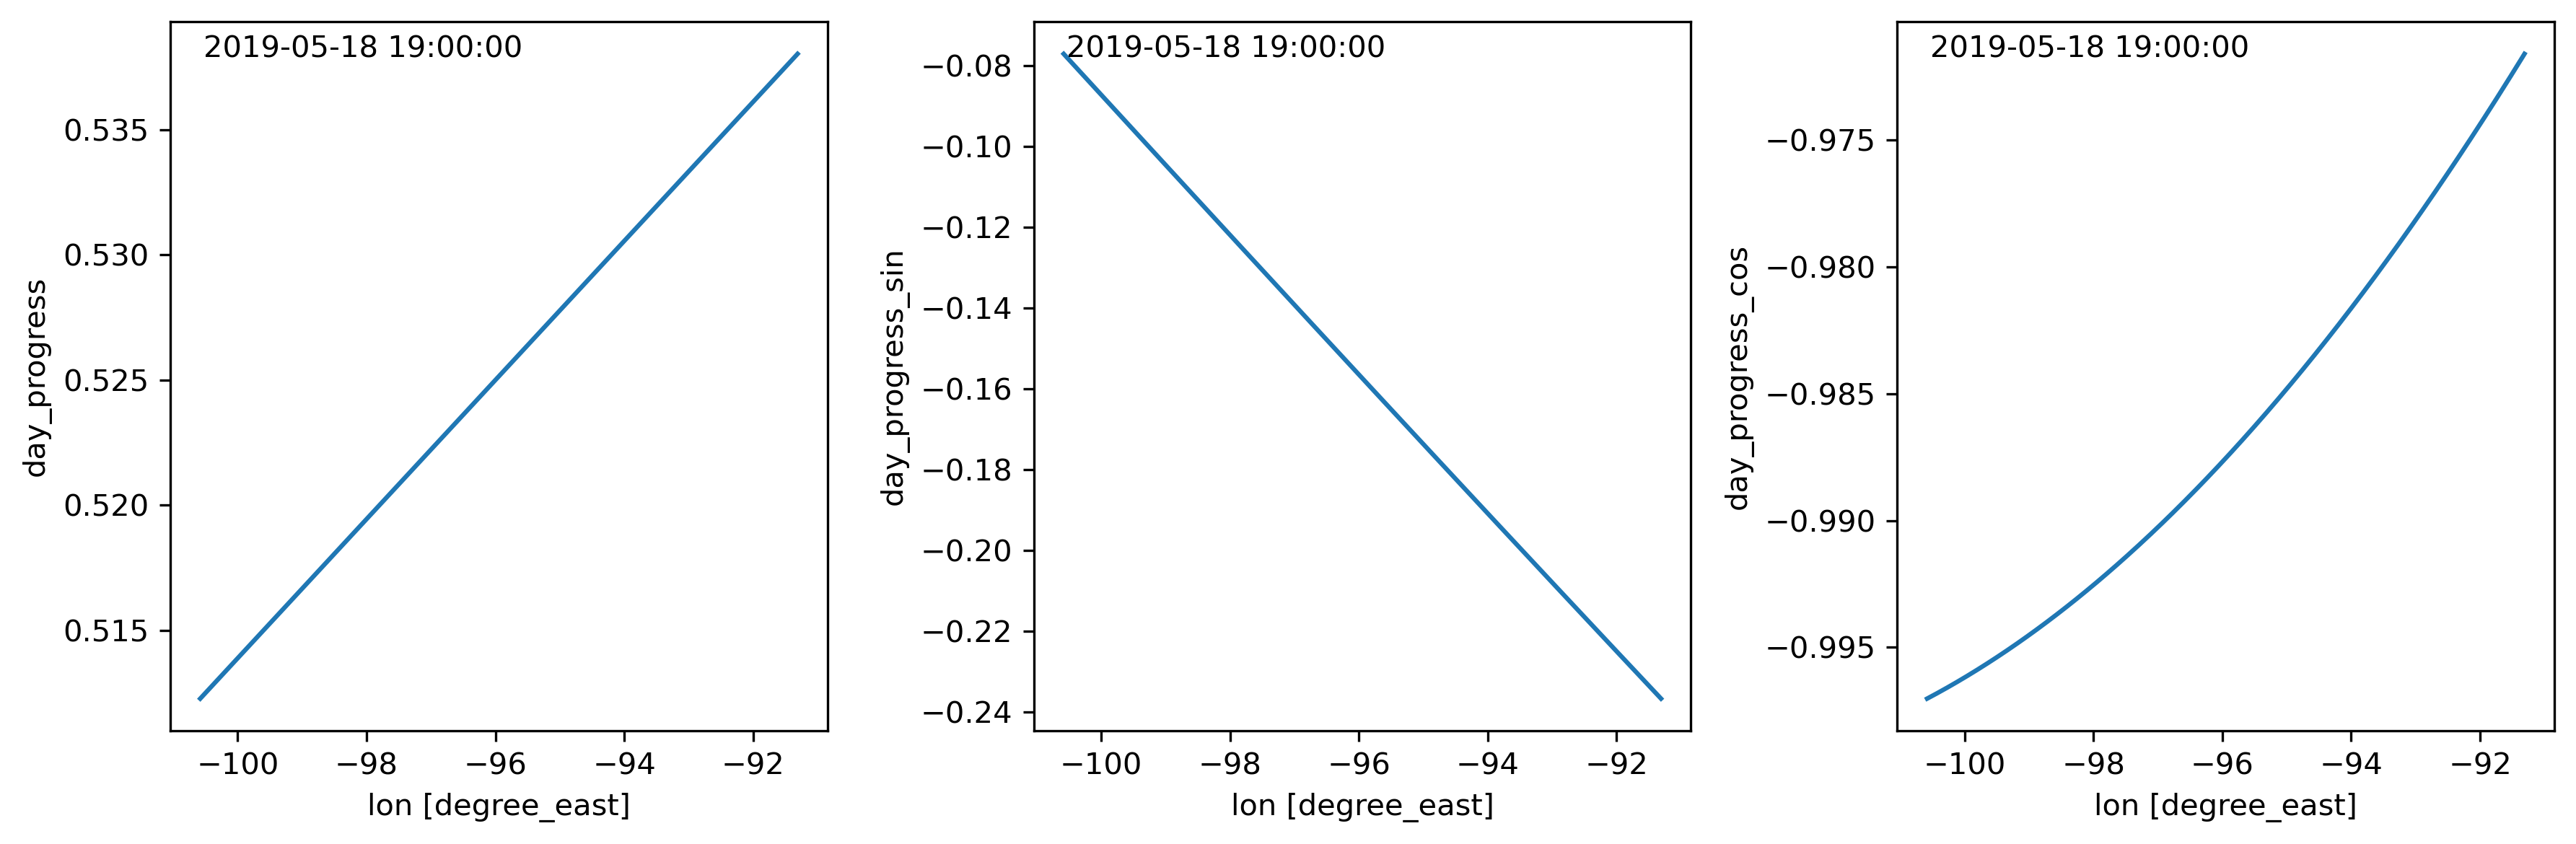

In [4]:
fig, axes = plt.subplots(dpi=300, figsize=(12,4), ncols=3)

vs = ['day_progress', 'day_progress_sin', 'day_progress_cos']
for i, ax in enumerate(axes):
    ds.isel(batch=0, time=0)[vs[i]].plot(ax=ax)
    ax.set_title('')
    
    # Convert the datetime value to a pandas Timestamp for easy formatting
    date_str = pd.to_datetime(ds.datetime[0].values).strftime('%Y-%m-%d %H:%M:%S')
    # Annotate the plot with the formatted date string
    ax.annotate(f'{date_str}', xy=(0.05, 0.95), xycoords='axes fraction')
    
plt.tight_layout()

Text(0.5, 1.0, '')

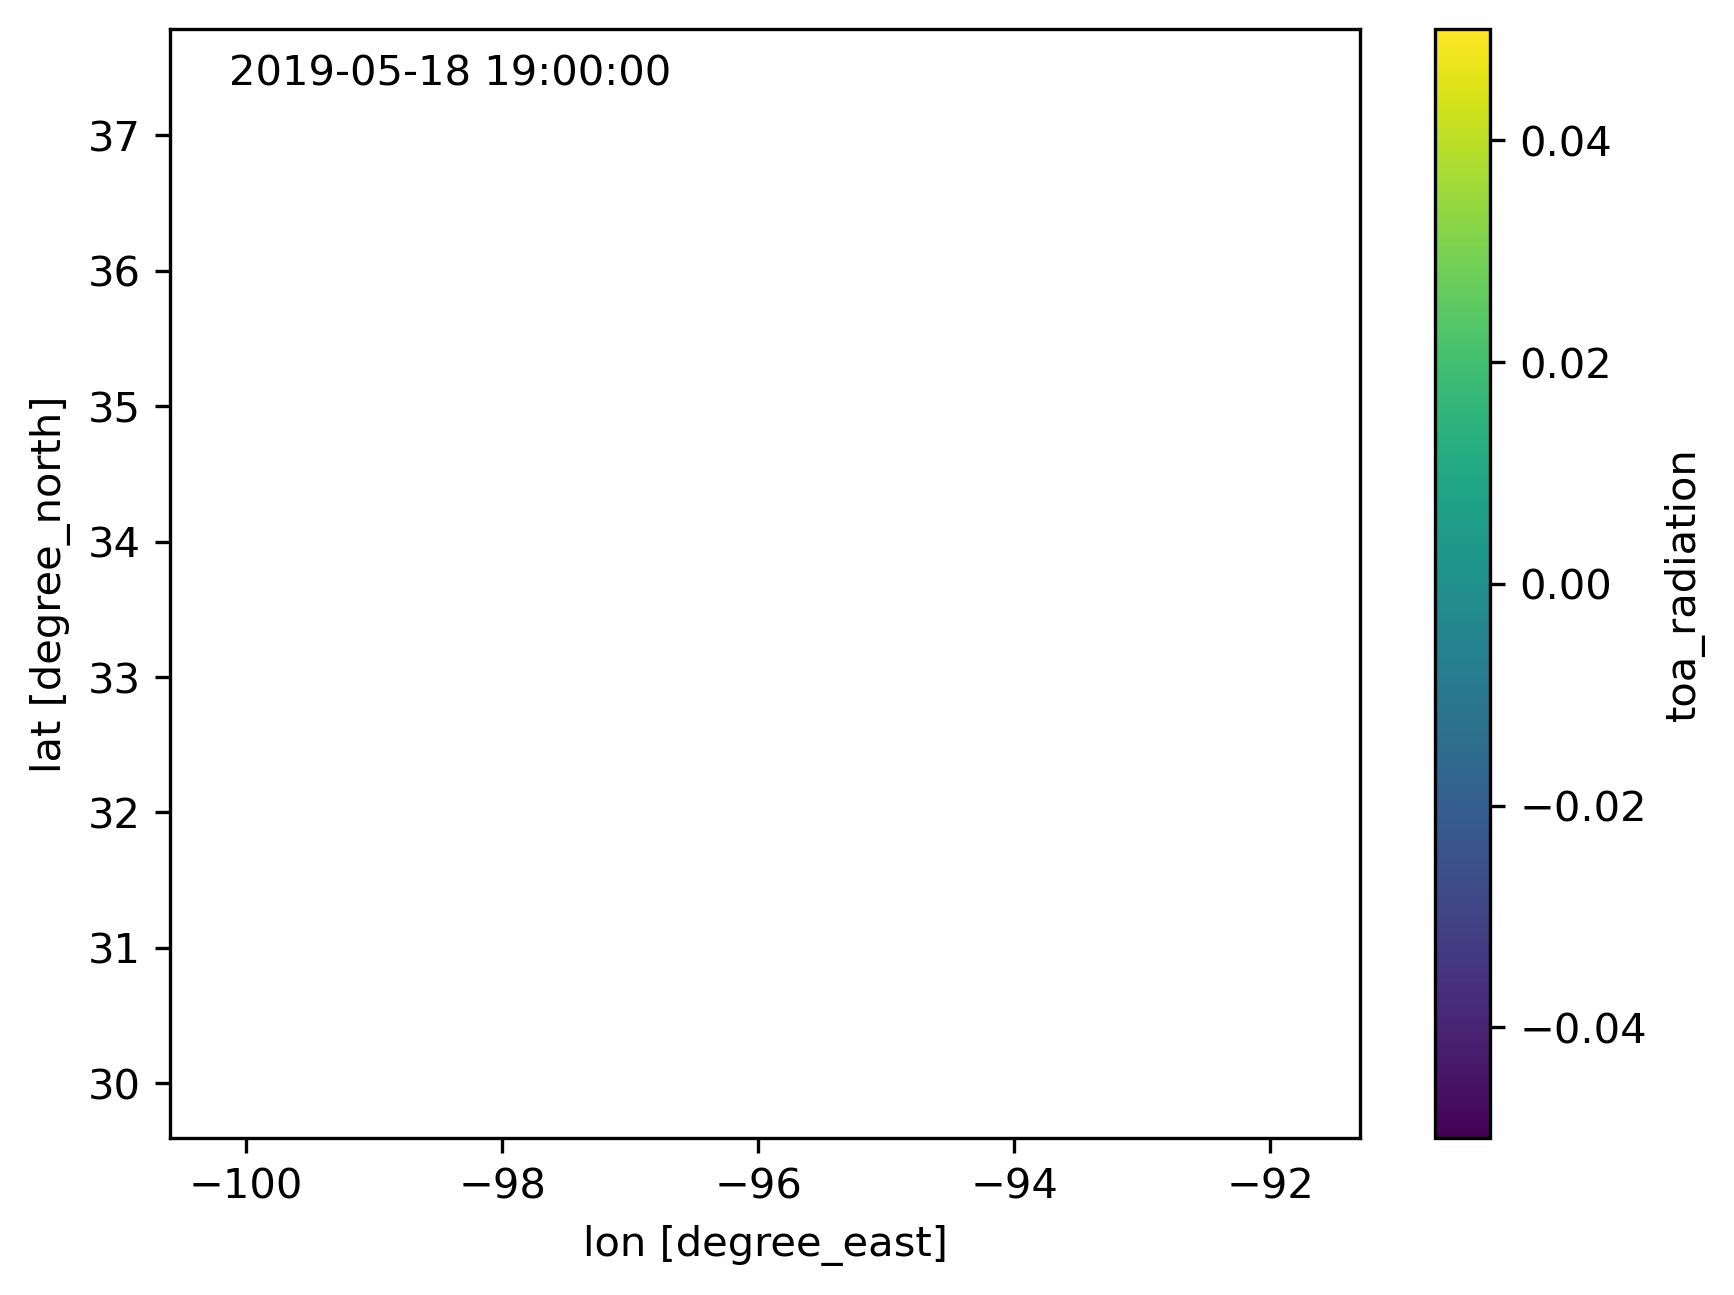

In [5]:
fig, ax = plt.subplots(dpi=300)

levels = np.arange(750, 1360, 10)

ds.isel(batch=0, time=0)['toa_radiation'].plot(ax=ax)#, levels=levels)
# Convert the datetime value to a pandas Timestamp for easy formatting
date_str = pd.to_datetime(ds.datetime[0].values).strftime('%Y-%m-%d %H:%M:%S')
# Annotate the plot with the formatted date string
ax.annotate(f'{date_str}', xy=(0.05, 0.95), xycoords='axes fraction')
ax.set_title('')

In [8]:
from datetime import datetime, timedelta

# Step 1: Define latitude, longitude, and time range
lat = np.linspace(-90, 90, 150)  # Latitude from 25°N to 50°N
lon = np.linspace(-180, 180, 150)  # Longitude from 120°W to 50°W
time = np.array([datetime(2024, 6, 21, 12, 0) + timedelta(hours=i) for i in range(24)])  # 24 hours

# Step 2: Create fake radiation flux data (flux values vary sinusoidally over time)
nt, nlat, nlon = len(time), len(lat), len(lon)
flux = np.zeros((nt, nlat, nlon))

for t in range(nt):
    flux[t] = np.outer(np.sin(np.radians(lat - 40)), np.cos(np.radians(lon + 85))) * (1 + np.sin(2 * np.pi * t / nt))


# Step 3: Create an xarray dataset
ds = xr.Dataset(
    {
        "flux": (["time", "lat", "lon"], flux)
    },
    coords={
        "time": time,
        "datetime" : time, 
        "lat": lat,
        "lon": lon
    }
)

ds = add_derived_vars(ds)
ds = add_toa_radiation(ds)

Time: 2024-06-21 12:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): -0.43
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.28
Time: 2024-06-21 13:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): 14.57
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.26
Time: 2024-06-21 14:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): 29.57
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.22
Time: 2024-06-21 15:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): 44.57
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.17
Time: 2024-06-21 16:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): 59.57
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.12
Time: 2024-06-21 17:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): 74.57
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.06
Time: 2024-06-21 18:00:00, Day: 173
Declination (degrees): 23.45
Hour Angle (degrees): 89.57
Cos(Zenith): -0.00
Zenith Angle (degrees): 90.00
Time: 

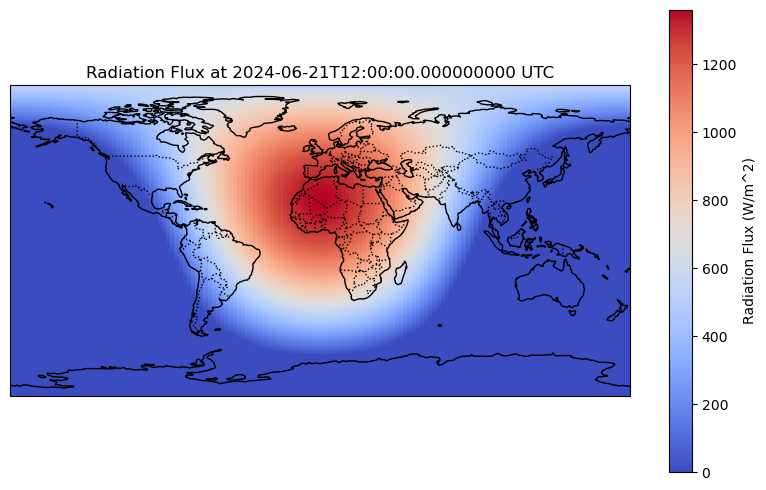

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import HTML

# Assuming lat, lon, ds['toa_radiation'], ds['day_progress_sin'], and ds['day_progress_cos'] are predefined

# Step 1: Set up the figure and Cartopy projection for the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Set initial plot for the TOA radiation
cax = ax.pcolormesh(lon, lat, ds['toa_radiation'].isel(time=0), cmap="coolwarm", shading='auto', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cax, ax=ax, label="Radiation Flux (W/m^2)")
ax.set_title("Radiation Flux Over Time")

# Step 2: Define the animation function
def animate(i):
    ax.clear()  # Clear the axis for the new frame

    # Re-add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Plot TOA radiation on the map
    cax = ax.pcolormesh(lon, lat, ds['toa_radiation'].isel(time=i), cmap="coolwarm", shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Radiation Flux at {ds.time.values[i]} UTC")

    # Re-attach the colorbar
    #fig.colorbar(cax, ax=ax, label="Radiation Flux (W/m^2)")

# Step 3: Create the animation
anim = FuncAnimation(fig, animate, frames=len(ds.time), interval=500)

# Step 4: Display the animation in the notebook
#HTML(anim.to_jshtml())

# Optional: To save the animation
anim.save(f"toa_radiation_cartopy.gif", writer="pillow", fps=3)